In [1]:
'''
This is a sandbox to work on proving that we can get digital 
sound out of scans of an optical track. If I can manually 
get it to work here, I can then take this PoC and turn it into
a full application.
'''
import cv2
import os
import matplotlib.pyplot as plt
import math
import numpy as np

extrailer25.jpeg
extrailer26.jpeg
extrailer27.jpeg
extrailer28.jpeg
extrailer29.jpeg
extrailer30.jpeg
extrailer31.jpeg
extrailer32.jpeg
extrailer33.jpeg
extrailer34.jpeg
extrailer35.jpeg
extrailer36.jpeg
extrailer37.jpeg
extrailer38.jpeg
extrailer39.jpeg
extrailer40.jpeg
extrailer41.jpeg
extrailer42.jpeg
extrailer43.jpeg
extrailer44.jpeg
extrailer45.jpeg
extrailer46.jpeg
extrailer47.jpeg
extrailer48.jpeg


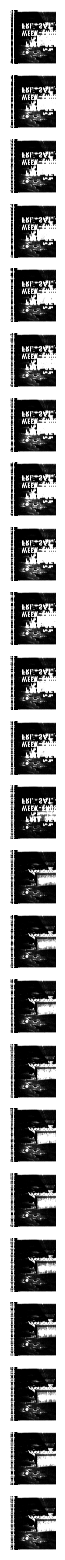

In [23]:
imagefiles = os.listdir("input\onesec\.")
imagefiles.sort()

images = []
cutoff = 0
for filename in imagefiles:
    if cutoff > 23:
        break

    img = cv2.imread("input\onesec\\" + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Default reads in as BGR, we want this as black and white
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    # Adjusts the brightness by adding 10 to each pixel value 
    brightness = 5
    # Adjusts the contrast by scaling the pixel values by 2.3 
    contrast = 3 
    img = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness) 

    # Create the sharpening kernel
    kernel = np.array([[-1,-1,-1], 
                       [-1,9,-1], 
                       [-1,-1,-1]])
    # Apply the sharpening kernel to the image using filter2D
    img = cv2.filter2D(img, -1, kernel)

    height,width = img.shape
    print(filename)
    #img = img[700:height-1000,400:width-2000]

    # This is to trim this exact scan images so that the end of the frames ~perfectly go into the nex
    img = img[965:height-1255,500:width-1000]
    
    # Rotate back
    # img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Make pixel 1 or 0, "thresholding". This is how we make the optical track either black or white
    ret,img = cv2.threshold(img,254,255,cv2.THRESH_BINARY)

    images.append(img)
    cutoff = cutoff + 1
num_images = len(images)

images = images[::-1] # Reverse the list order to get the expected order of the optical tracks


plt.figure(figsize=[30,20])
for i in range(0, num_images):
    plt.subplot(num_images, 1, i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray') # matplot reads the channels as RGB, so we need to tell it this is actually grey or we get weird channel issues

image1 = images[0]
image2 = images[1]

## Visualize the crop is correct by concatinating the two images

True

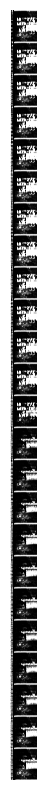

In [26]:
# Concatinated image to show merge visually
merged_images = cv2.vconcat(images)
plt.figure(figsize=[30,10])
plt.subplot(1, 1, 1)
plt.axis('off')
plt.imshow(merged_images, cmap='gray')
cv2.imwrite("mergedDemo.jpeg",merged_images)

## Get just the soundtrack